## Import des librairies et start application spark

In [1]:

import time, cv2
import os
import io
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow



# pyspark librairie
import pyspark 
## Spark
#import findspark
#findspark.init()
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

# tensorflow modules
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array


import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import warnings
import logging
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1663583550488_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# info application
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1663583550488_0003,pyspark,idle,Link,Link,None,✔


In [25]:
# utiliser ggplot style 
plt.style.use("ggplot")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Read les images depuis S3 

- [X] <font color=blue> Read 2 catégories (Raspberry et Mango) 
    

- [X] <font color=blue> 15 images Raspberry et 15 images Mango 

In [3]:
def read_S3_buckets_img(s3path):
    
    s3path = s3path

    # Read images avec le format binaryFile
    df_images = spark.read.format("binaryFile") \
      .option("pathGlobFilter", "*.jpg") \
      .option("recursiveFileLookup", "true") \
      .load(s3path)
    df_images.printSchema()
    
    return df_images



def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Read images mango et raspberry dans dossier différents

print("Mango dataframe")
df_images_mango = read_S3_buckets_img("s3a://ocfruitsp8/fruits_emr/mango/*")
print("Shape :",df_images_mango.shape())
df_images_mango

print("-----------------------------------------")

print("Raspberry dataframe")
df_images_raspberry = read_S3_buckets_img("s3a://ocfruitsp8/fruits_emr/raspberry/*")
print("Shape :",df_images_raspberry.shape())
df_images_raspberry

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mango dataframe
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

Shape : (15, 4)
-----------------------------------------
Raspberry dataframe
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

Shape : (15, 4)
DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [5]:
# Dataframe pyspark avec en colonnes path, content et label(jpg)
df_images_raspberry = df_images_raspberry.withColumn('label', split(col('path'), '/').getItem(4))
df_images_raspberry = df_images_raspberry.select('path', 'content', 'label')
print(df_images_raspberry.shape())
df_images_raspberry.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(15, 3)
+--------------------+--------------------+---------+
|                path|             content|    label|
+--------------------+--------------------+---------+
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
+-------------------

In [6]:
# Dataframe pyspark avec en colonnes path, content et label(jpg)
df_images_mango = df_images_mango.withColumn('label', split(col('path'), '/').getItem(4))
df_images_mango = df_images_mango.select('path', 'content', 'label')
print(df_images_mango.shape())
df_images_mango.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(15, 3)
+--------------------+--------------------+-----+
|                path|             content|label|
+--------------------+--------------------+-----+
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|mango|
+--------------------+--------------------+-----+

In [7]:
# Concatener df raspberry et mango (axis=0)
df_images = df_images_raspberry.unionByName(df_images_mango, allowMissingColumns=True)
df_images.printSchema()
print(df_images.shape())
df_images.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

(30, 3)
+--------------------+--------------------+---------+
|                path|             content|    label|
+--------------------+--------------------+---------+
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocfruitsp8/...|[FF D8 FF E0 00 1...|raspberry|
|s3a://ocf

In [8]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Features extraction ResNet50

- [X] <font color=blue> Supprimer les 2 derniéres couches 

In [12]:
# charge modéle
model = ResNet50(include_top=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

94773248/94765736 [==============================] - 0s 0us/step

In [13]:
#variable de diffusion. Les variables de diffusion permettent au programmeur de conserver une variable en lecture seule en cache sur chaque machine plutôt que d'en expédier une copie avec les tâches. Ils peuvent être utilisés, par exemple, pour donner à chaque nœud une copie d'un grand ensemble de données d'entrée de manière efficace. Spark tente également de distribuer des variables de diffusion à l'aide d'algorithmes de diffusion efficaces pour réduire les coûts de communication.

bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Appliquer la feature_udf sur content
df_features_extraction = df_images.select(col("path"), col("label"), featurize_udf("content").alias("features_extraction_ResNet50"))
df_features_extraction.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_extraction_ResNet50: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [15]:
# afficher la features extractions Resnet50
df_features_extraction.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+----------------------------+
|                path|    label|features_extraction_ResNet50|
+--------------------+---------+----------------------------+
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://ocfruitsp8/...|raspberry|        [0.0, 0.0, 0.0, 0...|
|s3a://o

In [16]:
# transform to vector 
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_features_extraction_1 = df_features_extraction.select(col("path"),  col("label"), to_vector(df_features_extraction["features_extraction_ResNet50"]).alias("features_extraction_ResNet50")) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Preprocessing 



- [X] <font color=blue> PCA
 
> k=7
    
> 55% variance expliquée pour 2 components

### Standarscaler (scaling)

In [17]:
# standardiser les features extractions Resnet50
scaler = StandardScaler(withMean=True, withStd=True,
                              inputCol='features_extraction_ResNet50',
                              outputCol='features_scaled_StandardScaler')
scaler_fit = scaler.fit(df_features_extraction_1)
df_features_scaled = scaler_fit.transform(df_features_extraction_1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Afficher features extractions scaled avec standarscaler
df_features_scaled.printSchema()
df_features_scaled.show() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_extraction_ResNet50: vector (nullable = true)
 |-- features_scaled_StandardScaler: vector (nullable = true)

+--------------------+---------+----------------------------+------------------------------+
|                path|    label|features_extraction_ResNet50|features_scaled_StandardScaler|
+--------------------+---------+----------------------------+------------------------------+
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.

In [20]:
# fit et transform PCA sur les données features_scaled_StandardScale
PCA = PCA(k=7, inputCol="features_scaled_StandardScaler", outputCol="features_pca")
model_PCA_fit = PCA.fit(df_features_scaled)
PCA_transformed = model_PCA_fit.transform(df_features_scaled)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# afficher dataframe avec features PCA
PCA_transformed.printSchema()
PCA_transformed.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_extraction_ResNet50: vector (nullable = true)
 |-- features_scaled_StandardScaler: vector (nullable = true)
 |-- features_pca: vector (nullable = true)

+--------------------+---------+----------------------------+------------------------------+--------------------+
|                path|    label|features_extraction_ResNet50|features_scaled_StandardScaler|        features_pca|
+--------------------+---------+----------------------------+------------------------------+--------------------+
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|[98.3656270320505...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|[88.7803466332628...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          [0.0,0.0,0.0,0.0,...|[95.7223947966706...|
|s3a://ocfruitsp8/...|raspberry|        [0.0,0.0,0.0,0.0,...|          

In [27]:
# afficher plot pour la variance expliquée en fonction nombre composante PCA
var = model_PCA_fit.explainedVariance.cumsum()
plt.figure(figsize=(12,8))
sns.lineplot(x=[i for i in range(8)], y=np.insert(var,0,0)*100,marker="o")
plt.title("Scree plot", size=30)
plt.xlabel('Principal component', fontsize=22)
plt.ylabel('Variance_explained %', fontsize=22)
plt.ylim(0,100)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# la variance expliquée pour chaques dimensions
var

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.3847107 , 0.54991919, 0.70502387, 0.80705559, 0.87827463,
       0.93989402, 1.        ])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

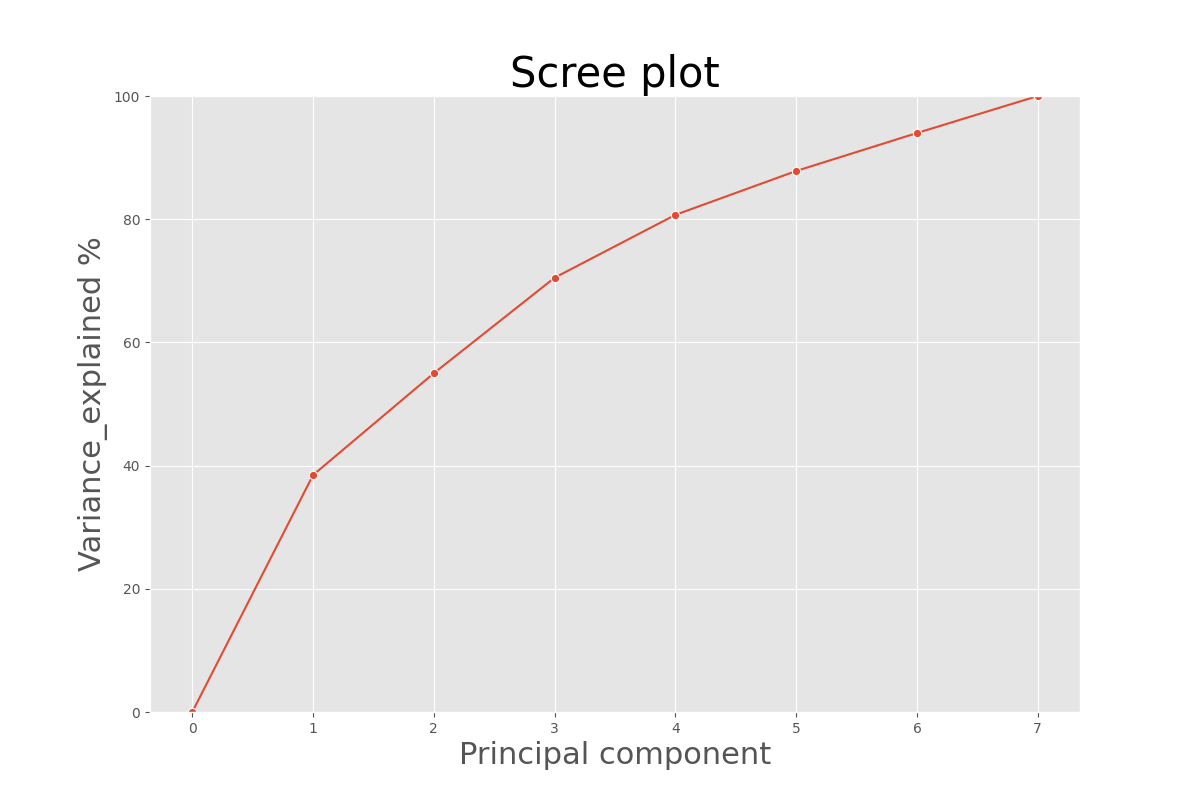

In [28]:
# pour afficher plot sur notebook EMR
%matplot plt

In [49]:
# Select colonnes et transform pandas
transformed_final = PCA_transformed.select('path', 'label', 'features_pca')
df_pandas = transformed_final.toPandas()
df_pandas

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                 path  ...                                       features_pca
0    s3a://ocfruitsp8/fruits_emr/raspberry/10_100.jpg  ...  [98.36562703205053, -109.32981338579948, -25.6...
1   s3a://ocfruitsp8/fruits_emr/raspberry/122_100.jpg  ...  [88.78034663326282, 48.41495427042844, 12.0250...
2    s3a://ocfruitsp8/fruits_emr/raspberry/11_100.jpg  ...  [95.72239479667061, -106.50639570287781, -25.2...
3    s3a://ocfruitsp8/fruits_emr/raspberry/12_100.jpg  ...  [104.15661051026423, -111.18585027992566, -22....
4   s3a://ocfruitsp8/fruits_emr/raspberry/120_100.jpg  ...  [87.76512996420675, 59.18856392184659, 13.8714...
5   s3a://ocfruitsp8/fruits_emr/raspberry/121_100.jpg  ...  [90.96808604296854, 52.52509875137343, 13.2983...
6   s3a://ocfruitsp8/fruits_emr/raspberry/119_100.jpg  ...  [89.87769233676806, 58.55758838180512, 13.1959...
7     s3a://ocfruitsp8/fruits_emr/raspberry/1_100.jpg  ...  [92.02261576360209, -124.20349047817433, -26.1...
8   s3a://

In [50]:
df_pandas[['label', 'features_pca']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        label                                       features_pca
0   raspberry  [98.36562703205053, -109.32981338579948, -25.6...
1   raspberry  [88.78034663326282, 48.41495427042844, 12.0250...
2   raspberry  [95.72239479667061, -106.50639570287781, -25.2...
3   raspberry  [104.15661051026423, -111.18585027992566, -22....
4   raspberry  [87.76512996420675, 59.18856392184659, 13.8714...
5   raspberry  [90.96808604296854, 52.52509875137343, 13.2983...
6   raspberry  [89.87769233676806, 58.55758838180512, 13.1959...
7   raspberry  [92.02261576360209, -124.20349047817433, -26.1...
8   raspberry  [89.46232279346336, 59.12461282691168, 12.8463...
9   raspberry  [95.66947792088757, 71.29659793219341, 16.3315...
10  raspberry  [89.85302850230484, 64.12540514611185, 14.7434...
11  raspberry  [91.82473268050346, -135.87607391798062, -28.8...
12  raspberry  [94.39499627737652, 62.706447626369275, 16.248...
13  raspberry  [93.83603891463089, 68.20368414185323, 15.8513...
14  raspberry  [91.496504

In [51]:
# Récupérer pca1 , pca2, pca3
X_pca1 = df_pandas['features_pca'].apply(lambda x :x[0])
X_pca2 = df_pandas['features_pca'].apply(lambda x :x[1])
X_pca3 = df_pandas['features_pca'].apply(lambda x :x[2])
df_plot = df_pandas[['label']]
df_plot['pca_1']= X_pca1
df_plot['pca_2']= X_pca2
df_plot['pca_3']= X_pca3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# Voir dataframe avce les 3 dimensions PCA
df_plot

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        label       pca_1       pca_2       pca_3
0   raspberry   98.365627 -109.329813  -25.630565
1   raspberry   88.780347   48.414954   12.025070
2   raspberry   95.722395 -106.506396  -25.273432
3   raspberry  104.156611 -111.185850  -22.207238
4   raspberry   87.765130   59.188564   13.871435
5   raspberry   90.968086   52.525099   13.298337
6   raspberry   89.877692   58.557588   13.195912
7   raspberry   92.022616 -124.203490  -26.195783
8   raspberry   89.462323   59.124613   12.846322
9   raspberry   95.669478   71.296598   16.331522
10  raspberry   89.853029   64.125405   14.743420
11  raspberry   91.824733 -135.876074  -28.887140
12  raspberry   94.394996   62.706448   16.248763
13  raspberry   93.836039   68.203684   15.851379
14  raspberry   91.496505   56.149195   12.786699
15      mango  -84.965653    2.272814  -17.089825
16      mango  -86.810272    1.439924  -14.885221
17      mango  -84.428133    1.157248  -19.014215
18      mango  -88.516857    3.800108  -22.795598


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

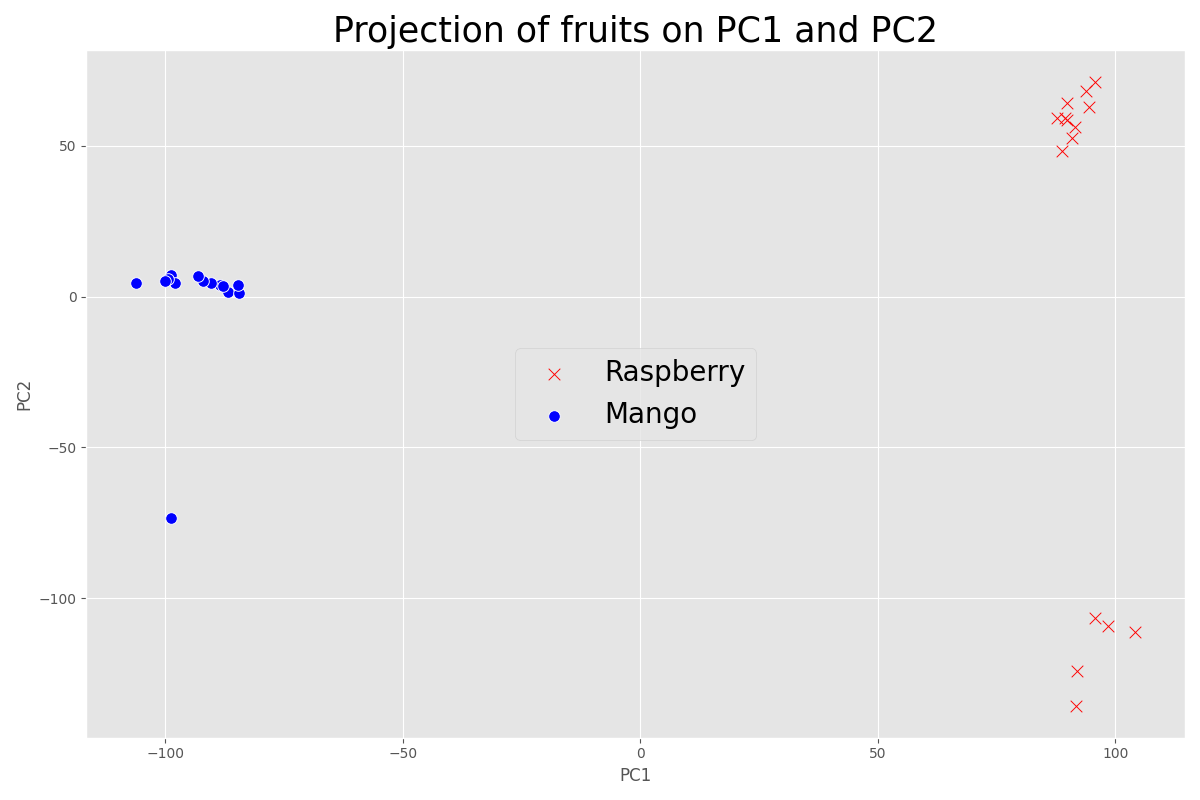

In [47]:
# afficher plot 2D avec les 2 premières composantes de la PCA 
plt.figure(figsize=(12,8))
sns.scatterplot(x = df_plot.iloc[0:15,1], y = df_plot.iloc[0:15,2], data = df_plot,label='Raspberry', marker="x", color="red", s=70)
sns.scatterplot(x = df_plot.iloc[15:,1], y = df_plot.iloc[15:,2], data = df_plot, label="Mango",marker="o", color="blue", s=70)
plt.title("Projection of fruits on PC1 and PC2",size=25)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc = "center", fontsize=20)
plt.tight_layout()
plt.show()
# pour afficher plot sur EMR notebook
%matplot plt

In [55]:
# sauvergarder dataframe pandas dans S3 bucket
df_final_pandas.to_csv('s3://bucketsavedata/pca_result/pca_result.csv', index=False)